In [1]:
import numpy as np

import jax
import jax.random as random
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from typing import List, Tuple, Dict

In [2]:
SEED = 42
MNIST_IMG_SIZE = (28, 28)
NUM_INP_NODES = np.prod(MNIST_IMG_SIZE)
NUM_CLASSES = 10

In [3]:
def init_MLP(layer_widths: List, parent_key, scale: float=0.01):

    params = []

    keys = random.split(parent_key, num=len(layer_widths) - 1)

    for num_in_nodes, num_out_nodes, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = random.split(key)

        params.append(
            [
                scale * random.normal(weight_key, shape=(num_out_nodes, num_in_nodes)),
                scale * random.normal(bias_key, shape=(num_out_nodes,)),
            ]
        )

    return params

In [4]:
# test
key = random.PRNGKey(SEED)
MLP_params = init_MLP([NUM_INP_NODES, 512, 256, NUM_CLASSES], key)
print(jax.tree,map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [5]:
def MLP_predict(params, x):
    hidden_layers = params[:-1]
    activation = x.T  # Transpose x to shape (784, 16)

    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    return logits - logsumexp(logits, axis=0)

In [6]:
# tests

# test single example

dummy_img_flat = np.random.randn(NUM_INP_NODES)
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

(784,)
(10,)


In [7]:
# test batched function

batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))
dummy_imgs_flat = np.random.randn(16, NUM_INP_NODES)
print(dummy_imgs_flat.shape)

predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(16, 784)
(16, 10)


In [8]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    """Required because pytorch will convert the images and labels into torch tensors."""
    transposed_data = list(zip(*batch))

    imgs = np.stack(transposed_data[0])
    labels = np.array(transposed_data[1])

    return imgs, labels

In [9]:
BATCH_SIZE = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 162569596.76it/s]


Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 20403519.26it/s]


Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 53134177.40it/s]

Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13956431.33it/s]


Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 145869452.12it/s]

Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26693630.19it/s]


Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67521517.17it/s]

Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4367383.94it/s]

Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



In [10]:
# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)


(128, 784) float32 (128,) int64


In [11]:
# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

In [12]:
def loss_fn(params, images, labels):
    prediction = batched_MLP_predict(params, images)

    return -jnp.mean(prediction * labels)


def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, images, labels, LR=0.01):

    loss, grads = value_and_grad(loss_fn)(params, images, labels)

    return loss, jax.tree,map(lambda p, g: p - LR * g, params, grads)

In [13]:
NUM_EPOCHS = 5
LR = 1e-2

In [14]:
# Create a MLP
MLP_params = init_MLP([NUM_INP_NODES, 512, 256, len(MNIST.classes)], key)

In [15]:
for epoch in range(NUM_EPOCHS):

    for cnt, (images, labels) in enumerate(train_loader):
        labels = jax.nn.one_hot(labels, NUM_CLASSES)
        loss, MLP_params = update(MLP_params, images, labels)

        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')

0.23171155
0.09165283
0.05621598
0.042950798
0.03402034
0.035646606
0.036917288
0.030157194
0.034105383
0.029084546
Epoch 0, train acc = 0.9139333367347717 test acc = 0.9192999601364136
0.02867355
0.022220254
0.01870563
0.031324904
0.023904303
0.024634408
0.019519094
0.017780393
0.023137921
0.009613656
Epoch 1, train acc = 0.9331499934196472 test acc = 0.932699978351593
0.022208096
0.025706936
0.022704443
0.013882316
0.020821128
0.02572376
0.029089449
0.024225676
0.012889358
0.014134101
Epoch 2, train acc = 0.9449499845504761 test acc = 0.9441999793052673
0.012241857
0.0184399
0.012950798
0.012680113
0.024132602
0.013984854
0.01624301
0.01316537
0.007929091
0.03083024
Epoch 3, train acc = 0.9523833394050598 test acc = 0.9497999548912048
0.0146932965
0.014012787
0.015066442
0.009161687
0.0063944045
0.021783315
0.017897358
0.014421195
0.022279842
0.0117606735
Epoch 4, train acc = 0.9585000276565552 test acc = 0.953499972820282


(28, 28)
pred 7
gt 7


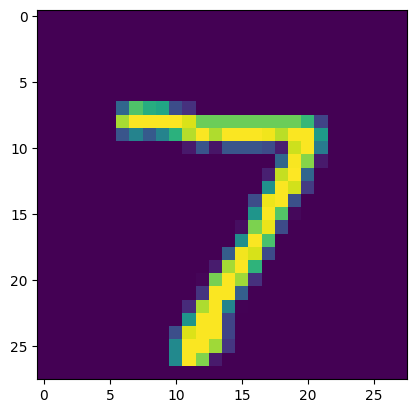

In [16]:
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(MNIST_IMG_SIZE)
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()